 Install Required Libraries

In [1]:
!pip install lightkurve tensorflow astroquery


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.4/270.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.8/910.8 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 93.4 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=7b0395980bee8f6ea5240adc01a0e3c099c758f5aa3d4d497bc99ff431399ff2
  Stored in directory: /root/.cache/pip/wheels/3c/ea/60/8d1c9fbbc99492a1775b36a5e29c8c1ef309cc5821bd5a219d
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-an

Import Necessary Libraries

In [17]:
import lightkurve as lk
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

Load TESS Data

In [4]:
target_ids = ['TIC 307210830', 'TIC 123456789', 'TIC 987654321']


/usr/local/lib/python3.10/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 56 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


<Axes: title={'center': 'Target ID: 307210830, Cadence: 151577'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

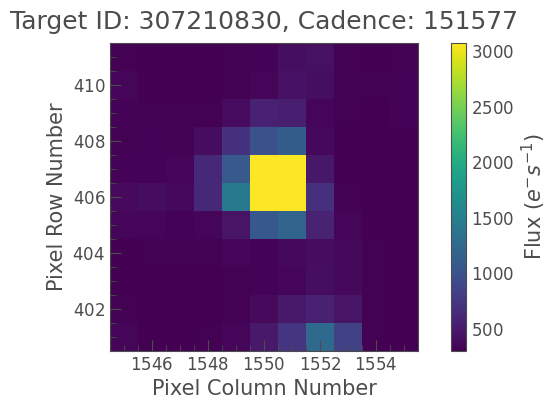

In [7]:
import lightkurve as lk
target_id = 'TIC 307210830'
tpf = lk.search_targetpixelfile(target_id, mission='TESS').download()
tpf.plot()


Plot the Light Curve

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

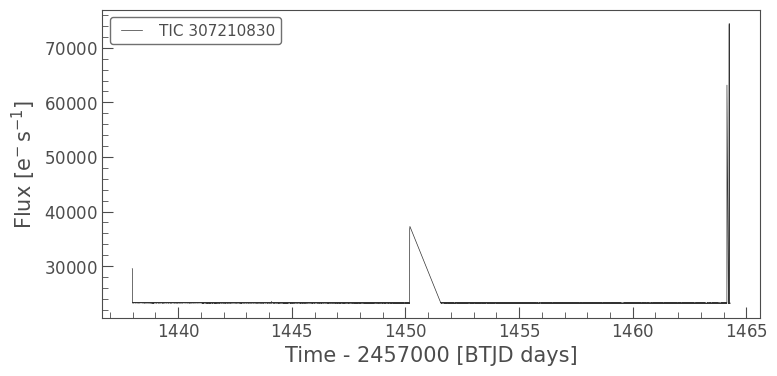

In [9]:
light_curve = tpf.to_lightcurve(method='aperture')
light_curve.plot(title=f"Light Curve for {target_id}")


Flatten the light curve

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

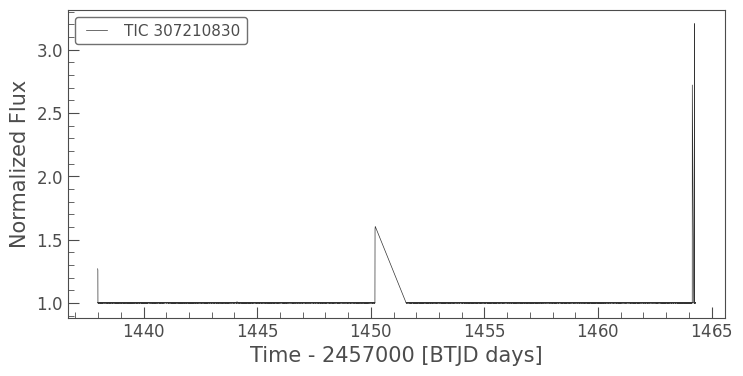

In [10]:
flattened_lc = light_curve.flatten()
flattened_lc.plot(title="Flattened Light Curve")

Fold the Light Curve

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

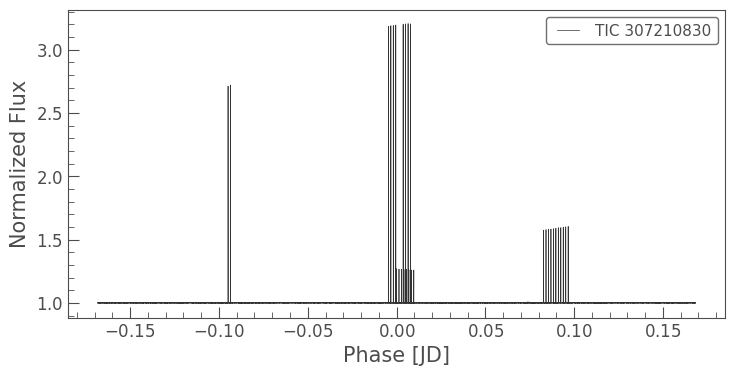

In [11]:
periodogram = flattened_lc.to_periodogram(method="bls")
best_period = periodogram.period_at_max_power

folded_lc = flattened_lc.fold(period=best_period)

folded_lc.plot(title=f"Folded Light Curve at Period {best_period:.5f} days")


Plot the Periodogram

<Axes: title={'center': 'Periodogram'}, xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

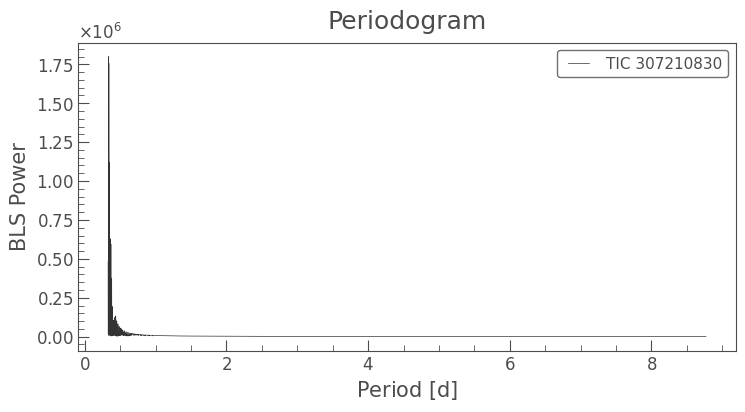

In [12]:
periodogram.plot(title="Periodogram")

Machine Learning for Gap Filling

In [13]:
X = folded_lc.time.value.reshape(-1, 1)
y = folded_lc.flux


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = Sequential([
    Dense(128, activation='relu', input_shape=(1,)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2287 - mae: 0.3271 - val_loss: 4.0362e-04 - val_mae: 0.0031
Epoch 2/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0138 - mae: 0.0808 - val_loss: 5.1176e-04 - val_mae: 0.0121
Epoch 3/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117 - mae: 0.0748 - val_loss: 4.6041e-04 - val_mae: 0.0080
Epoch 4/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0121 - mae: 0.0719 - val_loss: 4.1930e-04 - val_mae: 0.0050
Epoch 5/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0145 - mae: 0.0698 - val_loss: 4.6253e-04 - val_mae: 0.0069
Epoch 6/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0100 - mae: 0.0647 - val_loss: 4.5090e-04 - val_mae: 0.0088
Epoch 7/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088 - mae: 0.0603 - val_loss: 4.8621e-04 - val_mae: 0.0088
Epoch 8/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0102 - mae: 0.0568 - val_loss: 4.0345e-04 - val_mae: 0.0043
Epoch 9/50
355/355 ━━━━━━━━━━━━━━━━

Evaluate the Model

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2127e-04 - mae: 0.0054
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


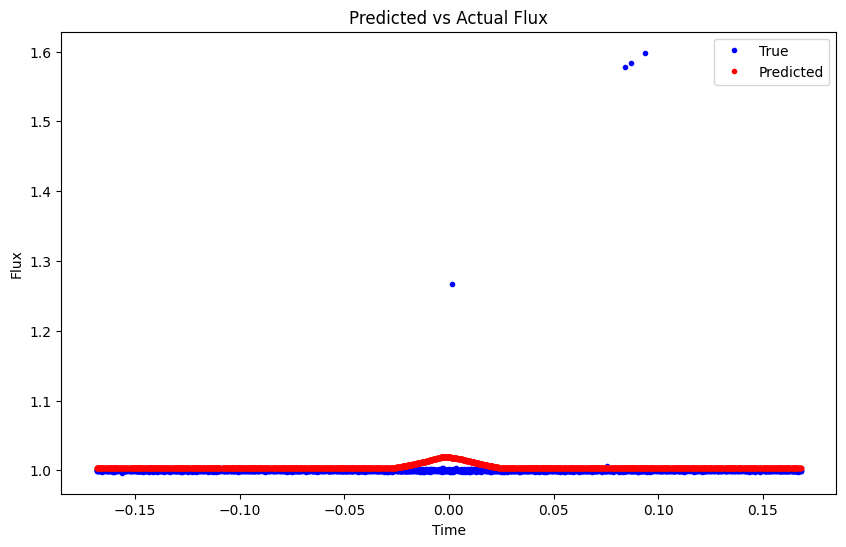

In [14]:
loss, mae = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.plot(X_test, y_test, 'b.', label='True')
plt.plot(X_test, y_pred, 'r.', label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Predicted vs Actual Flux')
plt.show()


Cross Validation

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae_scores = []

for train_index, val_index in kf.split(X):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
     model = Sequential([
        Dense(128, activation='relu', input_shape=(1,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    y_val_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_val_pred)
    cv_mae_scores.append(mae)
average_mae = np.mean(cv_mae_scores)
print(f'Cross-Validation MAE: {average_mae:.4f}')


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Cross-Validation MAE: 0.0056


Trying Gradient Boost

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)


GradientBoostingRegressor(n_estimators=200, random_state=42)

In [20]:
y_pred = gbr.predict(X_test)
gbr_mae = mean_absolute_error(y_test, y_pred)
print(f'Gradient Boosting MAE: {gbr_mae:.4f}')


Gradient Boosting MAE: 0.0036


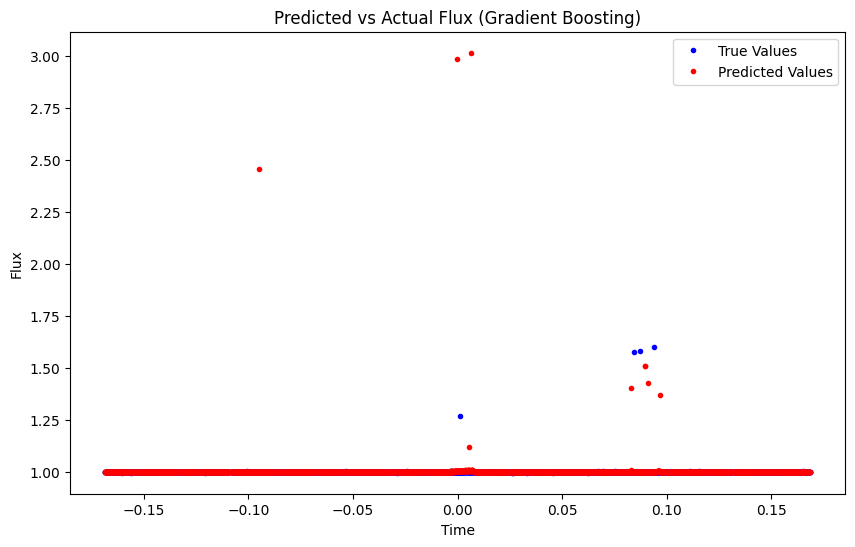

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, y_test, 'b.', label='True Values')
plt.plot(X_test, y_pred, 'r.', label='Predicted Values')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Predicted vs Actual Flux (Gradient Boosting)')
plt.show()


In [22]:
import joblib

In [23]:
joblib.dump(gbr, 'gradient_boosting_model.pkl')

['gradient_boosting_model.pkl']